# PREVISÃO DE TEMPERATURA UTILIZANDO LSTM

Neste *Notebook*, será realizada uma operação de previsão de séries temporais utilizando uma Rede Neural Recorrente (RNN) chamada Long Short-Term Memory network (LSTM), rede esta que é bastante utilizada para previsão de tempo e aplicações relacionadas [1].

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

## 1. Pré-processamento dos dados

Primeiramente o *dataset* será carregado, as amostras não desejadas serão eliminadas de maneira que somente será considerada apenas uma amostra por hora.

In [2]:
base = pd.read_csv("jena_climate_2009_2016.csv")
base = base[0::6]

Em seguida é feita a conversão do  o *index* para data e hora atual e feita sua padronização com a função `pd.to_datetime` no formato `DIA.MÊS.ANO HORA:MINUTO:SEGUNDO`

In [3]:
base['Date Time'] = pd.to_datetime(base['Date Time'],format = '%d.%m.%Y %H:%M:%S')
base = base.set_index(pd.DatetimeIndex(base['Date Time'].values))
base = base.drop('Date Time', axis = 1)
datelist_train = base.index

Podemos ter um vislumbre da característica de saída `T (degC)` conforme o tempo, para isso basta  plotar o seguinte gráfico:

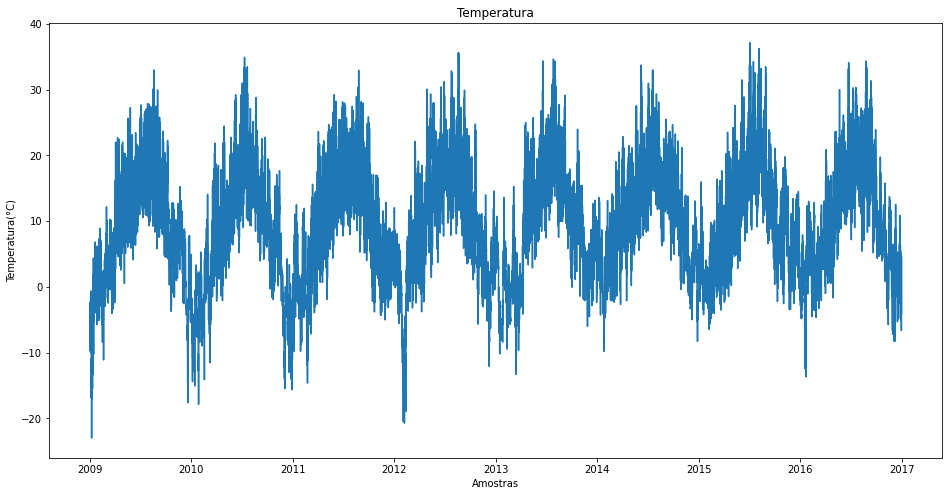

In [4]:
plt.figure(figsize=(16,8))
plt.xlabel('Amostras')
plt.ylabel('Temperatura(°C)')
plt.title('Temperatura')
plt.plot(base[['T (degC)']])
plt.show()

O LSTM é sensível à grandes variações de valores de atributos, portanto será feita uma normalização dos dados utilizando a função `scale.fit_transform`. Mais a frente esses valores serão revertidos para o valor original.

In [5]:
columns_titles = list(base)[:] #invertendo as colunas 0 e 1 para facilitar passos seguintes
aux = columns_titles[1] 
columns_titles[1] = columns_titles[0]
columns_titles[0] = aux
base=base.reindex(columns=columns_titles)
scale = StandardScaler()
base_norm = scale.fit_transform(base)
scale2 = StandardScaler() #obtendo scale2 para uso futuro na retomada dos dados ao valor original
y_norm = scale2.fit_transform(base[['T (degC)']])

O passo seguinte consiste em separar os dados entre treino e teste para mensurar a acurácia do LSTM, sendo utlizados 80% das amostras para treino e 20% para teste

In [6]:
q_treino =round(len(base_norm)*.80)
q_teste = len(base_norm) - q_treino
train = base_norm[:q_treino,:]
test = base_norm[q_treino:-1,:]

Em seguida será criada uma função que converte os dados de treino e teste para o formato desejado pela função `tensorflow.keras.layers.LSTM` que é um tensor de ordem 3 onde cada dimensão representa  a quantidade de amostras, *look back*  e a quantidade de características  respectivamente. O *look back* refere-se a quantas amostras anteriores devem ser consideradas para a previsão futura, neste caso temos um `lookback = 5`. Podemos assim seguir com a transformação dos dados de treino e teste e para o treino utilizando todos os dados. Além disso,todos os dados serão convertidos para este formato, para realizar a previsão de amostras futuras no passo final deste *Notebook*

In [7]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),1:14]        
        dataX.append(a)
        dataY.append(dataset[i + look_back,0])
    return np.array(dataX), np.array(dataY)

look_back=5
x_train,y_train = create_dataset(train,look_back)
x_test,y_test = create_dataset(test,look_back)
x_base, y_base = create_dataset(base_norm,look_back)

## 2. Treinamento

O passo seguinte consiste na criação da rede LSTM para o treinamento dos dados já pré-processados. Serão criados dois modelos, um para validação(`model`) e outro para previsão de amostras futuras,(`model2`), para ambos os modelos são criados duas camadas, cada uma com 13 neurônios. Também é criada uma camada extra utilizado a função `tensorflow.keras.layers.Dropout` para evitar um *overfitting* na rede. Por fim é adicionada uma camada densamente conectada utilizando a função `tensorflow.keras.layers.Dense`

In [8]:
model = Sequential()
model.add(LSTM(13, return_sequences = True,input_shape=(look_back, base_norm.shape[1]-1)))
model.add(LSTM(13, return_sequences = False))
model.add(Dropout(0.1))
model.add(Dense(1))

In [9]:
model2 = Sequential()
model2.add(LSTM(13, return_sequences = True,input_shape=(look_back, base_norm.shape[1]-1)))
model2.add(LSTM(13, return_sequences = False))
model2.add(Dropout(0.1))
model2.add(Dense(1))

Após a criação da rede será feito o treinamento, para isso foram utilizados Mean Squared Error (MSE) para cálculo da taxa de erro, otimizador `adam`, um fator `es` para parada em caso de não progressão da rede e um fato de parada de aprendizado `rlr` quando a rede não estiver mais aprendendo. Por fim o modelo `val` é treinado com 100 épocas e `batch_size = 256` (*mini-batch mode*).

In [10]:
model.compile(loss='mean_squared_error', optimizer='adam')
es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, verbose=1)
val = model.fit(x_train, y_train, epochs=100, callbacks=[es, rlr], verbose=1, batch_size=256)

Epoch 1/100
220/220 [==============================] - 5s 6ms/step - loss: 0.2000 - lr: 0.0010
Epoch 2/100
220/220 [==============================] - 1s 6ms/step - loss: 0.0571 - lr: 0.0010
Epoch 3/100
220/220 [==============================] - 1s 6ms/step - loss: 0.0334 - lr: 0.0010
Epoch 4/100
220/220 [==============================] - 1s 6ms/step - loss: 0.0247 - lr: 0.0010
Epoch 5/100
220/220 [==============================] - 1s 6ms/step - loss: 0.0213 - lr: 0.0010
Epoch 6/100
220/220 [==============================] - 1s 6ms/step - loss: 0.0197 - lr: 0.0010
Epoch 7/100
220/220 [==============================] - 1s 6ms/step - loss: 0.0191 - lr: 0.0010
Epoch 8/100
220/220 [==============================] - 1s 6ms/step - loss: 0.0183 - lr: 0.0010
Epoch 9/100
220/220 [==============================] - 1s 6ms/step - loss: 0.0178 - lr: 0.0010
Epoch 10/100
220/220 [==============================] - 1s 6ms/step - loss: 0.0178 - lr: 0.0010
Epoch 11/100
220/220 [===========================

Em seguida a rede é treinada com todos os dados

In [11]:
model2.compile(loss='mean_squared_error', optimizer='adam')
val_2 = model2.fit(x_base, y_base, epochs=100, callbacks=[es, rlr], verbose=1, batch_size=256)

Epoch 1/100
274/274 [==============================] - 5s 6ms/step - loss: 0.1513 - lr: 0.0010
Epoch 2/100
274/274 [==============================] - 2s 6ms/step - loss: 0.0446 - lr: 0.0010
Epoch 3/100
274/274 [==============================] - 2s 6ms/step - loss: 0.0273 - lr: 0.0010
Epoch 4/100
274/274 [==============================] - 2s 6ms/step - loss: 0.0220 - lr: 0.0010
Epoch 5/100
274/274 [==============================] - 2s 6ms/step - loss: 0.0197 - lr: 0.0010
Epoch 6/100
274/274 [==============================] - 2s 6ms/step - loss: 0.0188 - lr: 0.0010
Epoch 7/100
274/274 [==============================] - 2s 6ms/step - loss: 0.0182 - lr: 0.0010
Epoch 8/100
274/274 [==============================] - 2s 6ms/step - loss: 0.0179 - lr: 0.0010
Epoch 9/100
274/274 [==============================] - 2s 6ms/step - loss: 0.0177 - lr: 0.0010
Epoch 10/100
274/274 [==============================] - 2s 6ms/step - loss: 0.0177 - lr: 0.0010
Epoch 11/100
274/274 [===========================

## 3. Validação dos resultados

A validação dos resultados será feita graficamente, verificando o MSE conforme as épocas e visualizando os resultados de predição  de maneira lúdica. A seguir é visto o gráfico do MSE em relação às épocas de treinamento.

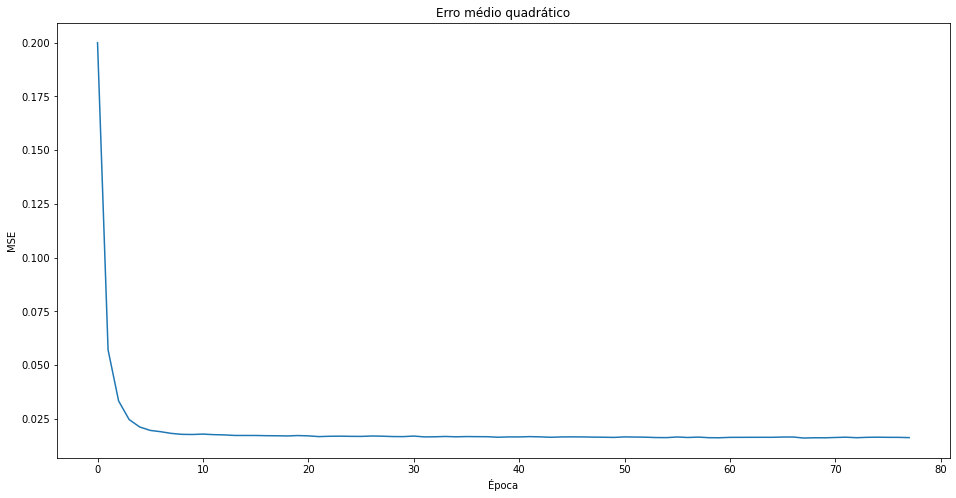

In [12]:
plt.figure(figsize=(16,8))
plt.plot(val.history['loss'])
plt.ylabel('MSE')
plt.title('Erro médio quadrático')
plt.xlabel('Época')
plt.show()

Agora será feita a previsão das amostras de teste (`x_test`) e a operação inversa à normalização dos dados reais de teste e dos dados previstos para serem comparados

In [13]:
prev = model.predict(x_test)
prev = scale2.inverse_transform(prev)
y_test = scale2.inverse_transform(np.reshape(y_test,(y_test.shape[0],1)))

438/438 [==============================] - 2s 2ms/step


Para melhor visualização dos dados é feita uma plotagem dos dados de temperatura (T (degC)) junto com o T (degC) previsto pela LSTM e a diferença (em valores absolutos) dos sinais ponto a ponto, isso proporciona uma boa visualização de quão acurada a rede está

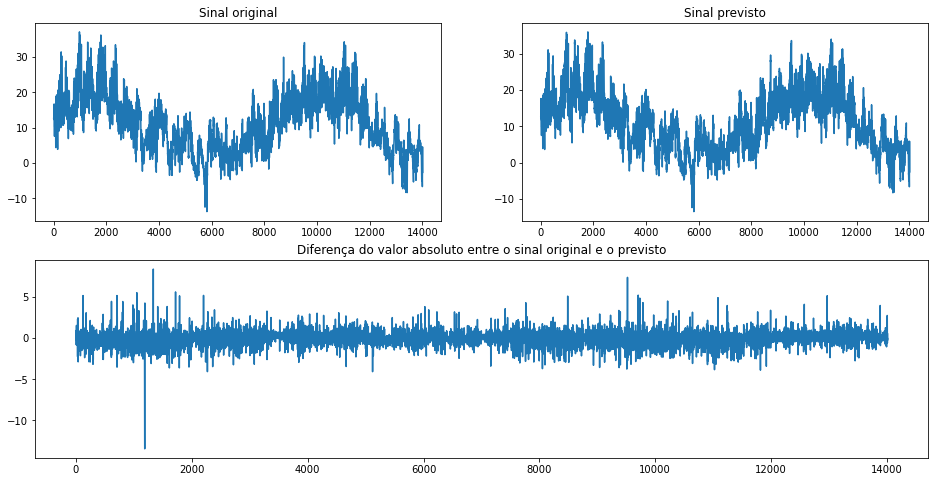

In [14]:
plt.figure(figsize=(16,8))
plt.title('Diferença entre a temperatura prevista e a real')

ax1 = plt.subplot(212)         
ax1.plot(np.abs(prev)-np.abs(y_test))
ax1.set_title('Diferença do valor absoluto entre o sinal original e o previsto')

ax2 = plt.subplot(221)           
ax2.plot(y_test)
ax2.set_title('Sinal original')

ax3 = plt.subplot(222)
ax3.plot(prev)
ax3.set_title('Sinal previsto')
plt.show()

## Previsão

Por fim, será feita a previsão de `n_future` amostras seguintes, primeiramente será feito um tratamento para os índices que serão herdados pelas amostras previstas

In [15]:
n_future = 20
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1H').tolist()
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

Em seguida realiza-se a previsão dos `n_future` dados requeridos utilizando o modelo treinado, obedecendo a restrição de *offset* de 2 valores.

In [16]:
offset = 2
predictions_future = model2.predict(x_base[-n_future-offset:-offset])

1/1 [==============================] - 1s 689ms/step


É feita agora a conversão dos dados para os valores reais e a indexação dos valores previstos

In [17]:
y_pred_future = scale2.inverse_transform(predictions_future)
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['T (degC)']).set_index(pd.Series(datelist_future))

Por fim, uma visualização gráfica e numérica dos valores previstos são mostrados abaixo

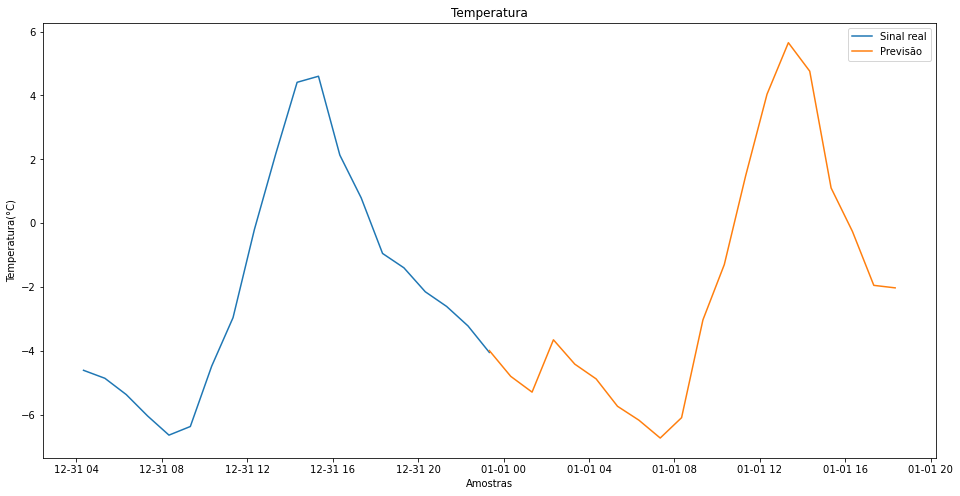

,T (degC)
2016-12-31 23:20:00,-3.992326
2017-01-01 00:20:00,-4.798520
2017-01-01 01:20:00,-5.293224
2017-01-01 02:20:00,-3.654484
2017-01-01 03:20:00,-4.416711
2017-01-01 04:20:00,-4.879202
2017-01-01 05:20:00,-5.736548
2017-01-01 06:20:00,-6.171103
2017-01-01 07:20:00,-6.731085
2017-01-01 08:20:00,-6.093369


In [18]:
plt.figure(figsize=(16,8))
plt.xlabel('Amostras')
plt.ylabel('Temperatura(°C)')
plt.title('Temperatura')
plt.plot(base[['T (degC)']].iloc[-n_future:], label ='Sinal real')
plt.plot(PREDICTIONS_FUTURE[['T (degC)']], label = 'Previsão')
plt.legend()
plt.show()
PREDICTIONS_FUTURE[['T (degC)']]

# Referências

[1] KAREVAN, Zahra; SUYKENS, Johan AK. Transductive LSTM for time-series prediction: An application to weather forecasting. Neural Networks, v. 125, p. 1-9, 2020.